<a href="https://colab.research.google.com/github/KelvinOliveira-S/Projeto_ML/blob/main/Trabalho_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. INSTALAÇÃO DE BIBLIOTECAS
!pip install boruta
!pip install imbalanced-learn

In [ ]:
# 2. IMPORTAÇÃO DAS BIBLIOTECAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
# 3. CARREGAMENTO DO DATASET
# Certifique-se de que o arquivo 'Accident_Information.csv' está no seu ambiente Colab.
# Se você carregou o .zip, descomente a linha abaixo para extraí-lo.
# !unzip Accident_Information.csv.zip

try:
    df = pd.read_csv('Accident_Information.csv', encoding='latin-1')
except FileNotFoundError:
    print("ERRO: Arquivo 'Accident_Information.csv' não encontrado.")
    print("Por favor, carregue o arquivo no seu ambiente Colab.")


/tmp/ipython-input-877852209.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Accident_Information.csv', encoding='latin-1')


In [ ]:
# 4. ANÁLISE EXPLORATÓRIA INICIAL
print("--- Informações do Dataset ---")
print(df.info())

print("\n--- 5 Primeiras Linhas ---")
print(df.head())

--- Informações do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 34 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   Accident_Index                               object 
 1   1st_Road_Class                               object 
 2   1st_Road_Number                              float64
 3   2nd_Road_Class                               object 
 4   2nd_Road_Number                              float64
 5   Accident_Severity                            object 
 6   Carriageway_Hazards                          object 
 7   Date                                         object 
 8   Day_of_Week                                  object 
 9   Did_Police_Officer_Attend_Scene_of_Accident  float64
 10  Junction_Control                             object 
 11  Junction_Detail                              object 
 12  Latitude                               

In [ ]:
# 1. TRATAMENTO DE VALORES AUSENTES E INVÁLIDOS
# Substituímos marcações de dados faltantes por NaN para um tratamento unificado.
df.replace(['Data missing or out of range', 'Not known', 'Unknown'], np.nan, inplace=True)

# 2. REMOÇÃO DE COLUNAS IRRELEVANTES
# Removemos colunas de ID, coordenadas brutas e outras que não contribuem para o modelo.
columns_to_drop = [
    'Accident_Index',
    'Location_Easting_OSGR',
    'Location_Northing_OSGR',
    'LSOA_of_Accident_Location',
    'Police_Force',
    'Date',
    'Time'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 3. IMPUTAÇÃO DE VALORES AUSENTES
# Preenchemos os valores NaN restantes. Usamos a moda para colunas de texto
# e a mediana para colunas numéricas, pois são mais robustas a outliers.
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].median(), inplace=True)

print("--- Verificação de Valores Ausentes Após Tratamento ---")
print(df.isnull().sum().any()) # Deve retornar False

# 4. CODIFICAÇÃO DA VARIÁVEL ALVO (Y)
le = LabelEncoder()
df[TARGET_COLUMN] = le.fit_transform(df[TARGET_COLUMN])
# Guardamos as classes para referência futura: 0: Fatal, 1: Serious, 2: Slight
le_classes = le.classes_
print(f"\nClasses da variável alvo codificadas: {list(enumerate(le_classes))}")

# 5. SEPARAÇÃO DE FEATURES (X) E ALVO (Y)
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# 6. CODIFICAÇÃO DAS FEATURES (X) - ONE-HOT ENCODING
# Convertemos variáveis categóricas em formato numérico que o modelo entende.
X = pd.get_dummies(X, drop_first=True)

# 7. DIVISÃO EM DADOS DE TREINO E TESTE
# Usamos estratificação (stratify=y) para manter a proporção das classes em ambos os conjuntos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 8. BALANCEAMENTO DE CLASSES COM SMOTE
# Como a classe 'Fatal' é rara, usamos SMOTE para criar exemplos sintéticos
# e balancear o conjunto de treino. Isso evita que o modelo ignore a classe minoritária.
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n--- Dimensões dos Dados Após Pré-processamento ---")
print(f"X_train (com SMOTE): {X_train_smote.shape}")
print(f"y_train (com SMOTE): {y_train_smote.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

print("\n--- Distribuição das Classes no Treino (Após SMOTE) ---")
print(y_train_smote.value_counts())

/tmp/ipython-input-2484410855.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
/tmp/ipython-input-2484410855.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

--- Verificação de Valores Ausentes Após Tratamento ---
False

Classes da variável alvo codificadas: [(0, 'Fatal'), (1, 'Serious'), (2, 'Slight')]


In [ ]:
# 5. ANÁLISE DA VARIÁVEL ALVO
# A variável alvo (Y) será 'Accident_Severity', que classifica a gravidade do acidente.
TARGET_COLUMN = 'Accident_Severity'
print(f"\n--- Contagem de Classes em '{TARGET_COLUMN}' ---")
print(df[TARGET_COLUMN].value_counts())



--- Contagem de Classes em 'Accident_Severity' ---
Accident_Severity
Slight     1734548
Serious     286339
Fatal        26369
Name: count, dtype: int64


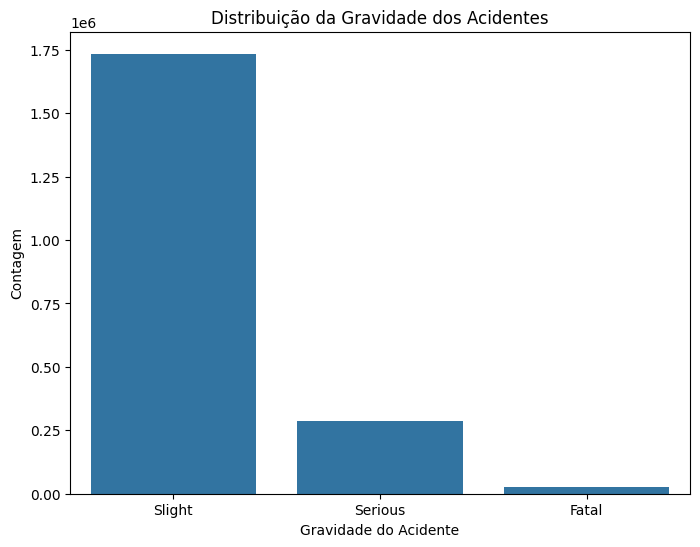

In [ ]:
# Visualização da distribuição da variável alvo
plt.figure(figsize=(8, 6))
sns.countplot(x=TARGET_COLUMN, data=df, order=df[TARGET_COLUMN].value_counts().index)
plt.title('Distribuição da Gravidade dos Acidentes')
plt.xlabel('Gravidade do Acidente')
plt.ylabel('Contagem')
plt.show()

In [ ]:
# 1. IMPORTAÇÃO DAS BIBLIOTECAS DE SELEÇÃO
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from boruta import BorutaPy

# 2. SELEÇÃO DE VARIÁVEIS COM BORUTA
print("--- Iniciando Seleção de Variáveis com Boruta... ---")
# O Boruta usa um modelo (Random Forest) para julgar a importância das features.
rf_boruta = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta_selector = BorutaPy(estimator=rf_boruta, n_estimators='auto', max_iter=50, random_state=42, verbose=2)

# O Boruta espera arrays numpy
boruta_selector.fit(X_train_smote.values, y_train_smote.values)

# 3. RESULTADOS DO BORUTA
boruta_confirmed_features = X_train_smote.columns[boruta_selector.support_].tolist()
print(f"\n--- Variáveis Confirmadas pelo Boruta ({len(boruta_confirmed_features)}) ---")
print(boruta_confirmed_features)

# 4. FILTRANDO OS DATASETS COM AS VARIÁVEIS SELECIONADAS
# Usaremos apenas as features que o Boruta considerou importantes.
X_train_final = X_train_smote[boruta_confirmed_features]
X_test_final = X_test[boruta_confirmed_features]

print("\n--- Dimensões Finais dos Dados para Modelagem ---")
print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")


In [ ]:
# 1. IMPORTAÇÃO DAS BIBLIOTECAS DE MODELAGEM E AVALIAÇÃO
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix

# 2. TREINAMENTO DO MODELO BASELINE
# Usamos o Random Forest, um algoritmo versátil e poderoso.
print("--- Treinando Modelo Baseline (Random Forest)... ---")
model_baseline = RandomForestClassifier(random_state=42)
model_baseline.fit(X_train_final, y_train_smote)

# Avaliação do Baseline
y_pred_baseline = model_baseline.predict(X_test_final)
acc_baseline = accuracy_score(y_test, y_pred_baseline)
rec_baseline = recall_score(y_test, y_pred_baseline, average='weighted')

print("\n--- Resultados do Modelo Baseline ---")
print(f"Acurácia: {acc_baseline:.4f}")
print(f"Recall (Ponderado): {rec_baseline:.4f}")
print(classification_report(y_test, y_pred_baseline, target_names=le_classes))

# 3. OTIMIZAÇÃO COM GRID SEARCH E VALIDAÇÃO CRUZADA
print("\n--- Otimizando o Modelo com Grid Search... ---")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='recall_weighted',
                           cv=cv_strategy,
                           verbose=2,
                           n_jobs=-1)
grid_search.fit(X_train_final, y_train_smote)

best_model = grid_search.best_estimator_
print(f"\nMelhores Hiperparâmetros: {grid_search.best_params_}")

# 4. AVALIAÇÃO DO MODELO OTIMIZADO
y_pred_optimized = best_model.predict(X_test_final)
acc_optimized = accuracy_score(y_test, y_pred_optimized)
rec_optimized = recall_score(y_test, y_pred_optimized, average='weighted')

print("\n--- Resultados do Modelo Otimizado ---")
print(f"Acurácia: {acc_optimized:.4f}")
print(f"Recall (Ponderado): {rec_optimized:.4f}")
print(classification_report(y_test, y_pred_optimized, target_names=le_classes))

# 5. COMPARAÇÃO FINAL E MATRIZ DE CONFUSÃO
print("\n--- Comparação Final de Desempenho ---")
comparison_results = pd.DataFrame({
    'Modelo': ['Baseline', 'Otimizado'],
    'Acurácia': [acc_baseline, acc_optimized],
    'Recall (Ponderado)': [rec_baseline, rec_optimized]
})
print(comparison_results)

# Matriz de Confusão do Modelo Otimizado
cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_classes, yticklabels=le_classes)
plt.title('Matriz de Confusão - Modelo Otimizado')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()
